# Requirements
* 1.Walk through your model step by step, starting with EDA
    * What are your variables of interest?
    * What outliers did you remove?
    * What types of data imputation did you perform?
 
* 2.Summarize your statistical analysis, including:
    * model selection
    * implementation
    * evaluation
    * inference

# Identify Sentiment from Reviews

#### Reviews were scrapped from Whirlpool Forums

### Assumption
* Not applicable

### Variables of interest
* The reviews scrapped

### Outliers
*  There are no outliers

### Data Imputation
* No data imputation was required as the data are reviews

### EDA
* Apply the English stopwords to remove the irrelavant words

### Models used:
* TextBlob - provides functions to determine if specific words are sad, happy or neutral
* TF-IDF - to ensure the count of words are proportionate as this impacts the model
   
### Inference/ Result
* The accuracy score of 0.72 suggest that the reviews about residential aged care is more positive than negative considering the topics are related to illness, the infirmed, death, depression, sickness etc. This suggest that entering a residential aged care is a necessary rather than emotional decision. 

In [1]:
# initialize the imports
import scipy.stats as stats
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io import sql
import sqlite3


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# initialize the imports
import sqlite3
sqlite_db = './openlib.db'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

In [3]:
# In case typing out `sql.read_sql()` is a little too much, create a function shortcut.

c = sqlite3.connect('./openlib.db')

def Q(query, db=c):
    return sql.read_sql(query, db)

In [4]:
# initialize the imports
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

## Reading the review table

In [5]:
# Select the reviews from the scraping
SQL_STRING = '''

SELECT *
FROM review
'''
review= pd.read_sql(SQL_STRING, con=conn)
review.head()

,review
0,"\nO.P.\n...home.\nMy dad, he is almost 81 and ..."
1,NA
2,"\nYou are not a bad person, it's all part of a..."
3,"\ncrunchyone writes...\nLately, and please don..."
4,\npeople have the wrong idea about nursing hom...


## Apply Textblob and Sentiment Analysis
* Convert reviews to Textblob and extract sentiment

In [6]:
# Calculate the sentiment for every review in the full dataset as a new column.
# Define a function that accepts text and returns the polarity
review[['polarity', 'subjectivity']] = review['review'].apply(lambda r: pd.Series(TextBlob(r).sentiment))

In [7]:
# Determine the polarity for the whole dataframe
# Define the function
def analize_sentiment(review):
    '''
    Utility function to classify the polarity of a 
    using textblob.
    '''
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [8]:
# We create a column with the result of the analysis:
review['sent_score'] = np.array([analize_sentiment(review) for review in review['review'] ])

# We display the updated dataframe with the new column:
display(review.head())

,review,polarity,subjectivity,sent_score
0,"\nO.P.\n...home.\nMy dad, he is almost 81 and ...",-0.036222,0.608725,-1
1,NA,0.000000,0.000000,0
2,"\nYou are not a bad person, it's all part of a...",0.158333,0.647222,1
3,"\ncrunchyone writes...\nLately, and please don...",-0.215000,0.525000,-1
4,\npeople have the wrong idea about nursing hom...,0.150000,0.539247,1


In [9]:
# We construct lists with classified reviews:

happy = [ sa for index, sa in enumerate(review['review']) if review['sent_score'][index] > 0]
neutral = [sa for index, sa in enumerate(review['review']) if review['sent_score'][index] == 0]
sad = [ sa for index, sa in enumerate(review['review']) if review['sent_score'][index] < 0]

In [10]:
# We print percentages:

print("Percentage of positive: {}%".format(len(happy)*100/len(review['review'])))
print("Percentage of neutral: {}%".format(len(neutral)*100/len(review['review'])))
print("Percentage of negative: {}%".format(len(sad)*100/len(review['review'])))

# Indicates the reviews are more positive than negative considering it is about aged care

Percentage of positive: 67.42424242424242%
Percentage of neutral: 8.333333333333334%
Percentage of negative: 24.242424242424242%


In [11]:
# review the columns
review.columns

Index(['review', 'polarity', 'subjectivity', 'sent_score'], dtype='object')

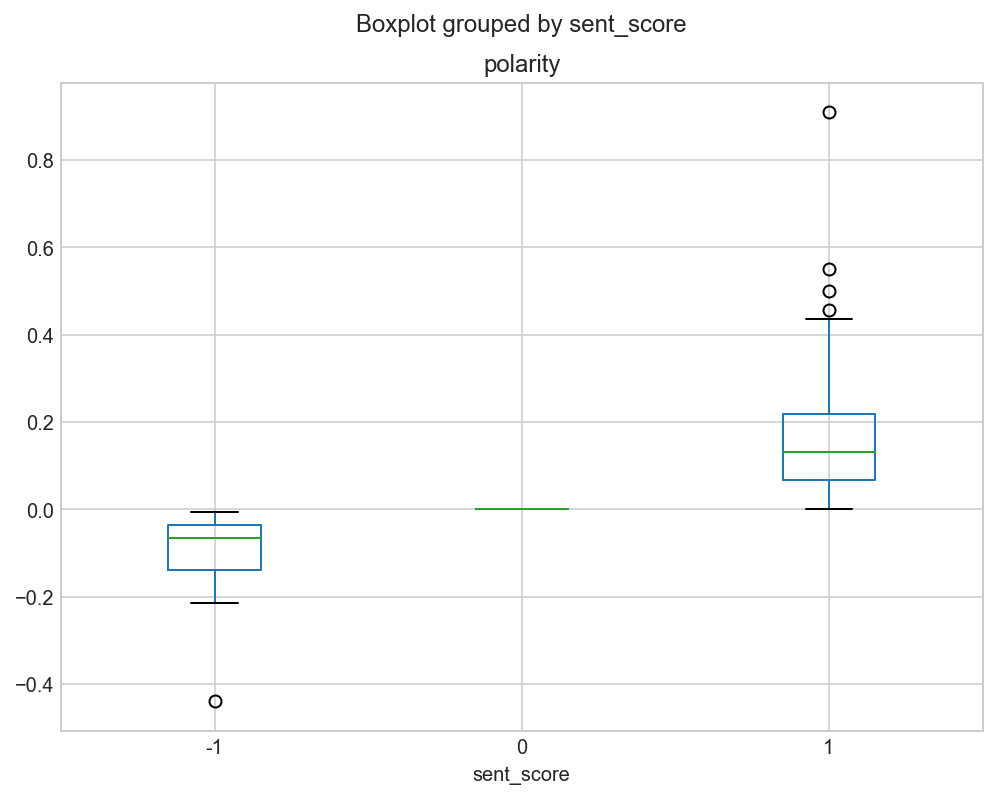

In [12]:
# Create a boxplot of sentiment by score rating
# box plot of sentiment grouped by score
review.boxplot(column='polarity', by='sent_score',figsize=(8,6))

In [13]:
# Print reviews with the highest and lowest sentiment.
# reviews with most positive sentiment
review[review.polarity >= 0].review.head()

1                                                   NA
2    \nYou are not a bad person, it's all part of a...
4    \npeople have the wrong idea about nursing hom...
5    \nAnother thing to remember, if your folks are...
6    \nVery hard situation.\nMaybe if you can get a...
Name: review, dtype: object

In [14]:
# reviews with most negative sentiment
review[review.polarity < 0].review.head()

0     \nO.P.\n...home.\nMy dad, he is almost 81 and ...
3     \ncrunchyone writes...\nLately, and please don...
9     \nSorry, I have no words of wisdom or advice b...
11    \nCan your parents afford in home care? we put...
17    \nNo need to feel guilty about it at all every...
Name: review, dtype: object

## Subset the reviews

In [15]:
# define X and y
X = review.review
y = review.sent_score

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [16]:
print(len(X_train))
print(len(X_test))

99
33


## Using TF-IDF to Summarize Reviews
* What: Computes "relative frequency" that a word appears in a document compared to its frequency across all documents
* Why: More useful than "term frequency" for identifying "important" words in each document (high frequency in that document, low frequency in other documents)
* Notes: Used for search engine scoring, text summarization, document clustering

* Build a simple TF-IDF using CountVectorizer
    * Term Frequency can be calulated with default CountVectorizer.
    * Inverse Document Frequency can be calculated with CountVectorizer and argument binary=True.

In [17]:
# Apply stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

custom_stop_words = list(ENGLISH_STOP_WORDS)

# You can of course add your own custom stopwords
custom_stop_words.append('NA')

In [18]:
# Define a function for the TfidfVectorizer
def tokens(x):
    return x.split(',')

In [19]:
# Build a TF-IDF predictor matrix excluding stopwords with TfidfVectorizer

tfidf_vect= TfidfVectorizer(tokenizer=tokens ,use_idf=True, smooth_idf=True, sublinear_tf=False,stop_words=custom_stop_words,ngram_range=(1, 2))

In [20]:
# create a document-term matrix using TF-IDF
X_train_dtm=tfidf_vect.fit_transform(X_train)
X_test_dtm =tfidf_vect.transform(X_test)
features=tfidf_vect.get_feature_names()
X_train_dtm.shape

(99, 969)

In [21]:
#print(tfidf_vect.get_feature_names()[-50:])

In [22]:
# show vectorizer options
tfidf_vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['again', 'although', 'why', 'while', 'except', 'ten', 'whereafter', 'will', 'top', 'cry', 'nothing', 'thence', 'thru', 'de', 'latter', 'until', 'us', 'also', 'not', 'or', 'his', 'six', 'an', 'as', 'twelve', 'forty', 'himself', 'how', 'rather', 'here', 'she', 'so', 'been', 'through', 'can..., 'same', 'first', 'in', 'fifteen', 'such', 'him', 'many', 'whereby', 'those', 'give', 'next', 'NA'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokens at 0x0000022D72569BF8>, use_idf=True,
        vocabulary=None)

## Predict the sentiment score with the features from TfidfVectorizer.
Validate on the test set.

In [23]:
# use Naive Bayes  to predict the sentiment score
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.7272727272727273


In [24]:
# calculate null accuracy
y_test_binary = np.where(y_test==5, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

1.0

In [25]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(tfidf_vect):
    X_train_dtm = tfidf_vect.fit_transform(X_train)
    print('Features: ', X_train_dtm.shape[1])
    X_test_dtm = tfidf_vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [26]:
# print
tokenize_test(tfidf_vect)
## The accuracy of 0.72 confirms that the sentiments about aged care is more positive

Features:  969
Accuracy:  0.7272727272727273
